In [1]:
# https://www.kaggle.com/c/homesite-quote-conversion/data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, norm, entropy, gaussian_kde
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
plt.style.use('fivethirtyeight')
%matplotlib inline

# figure out how to entropy and get pdf of function later

/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


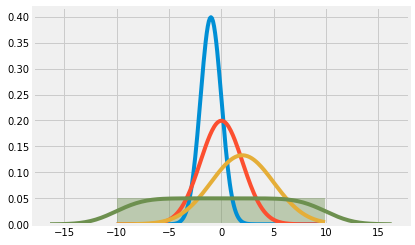

In [2]:
# distplot distribution# for entropy
# https://stackoverflow.com/questions/26743201/interpreting-scipy-stats-entropy-values

#initialize a normal distribution with frozen in mean=-1, std. dev.= 1
rv = norm(loc = -1., scale = 1.0)
rv1 = norm(loc = 0., scale = 2.0)
rv2 = norm(loc = 2., scale = 3.0)
rv5 = norm(loc = 5., scale = 3.0)

x = np.arange(-10, 10, .1)

#plot the pdfs of these normal distributions 
plt.plot(x, rv.pdf(x), x, rv1.pdf(x), x, rv2.pdf(x))
sns.distplot(x) # dark green

In [3]:
gaussian_kde(x)

In [4]:
print x[:5], len(x)
print rv1.pdf(x)[:5], len(rv1.pdf(x))


[-10.   -9.9  -9.8  -9.7  -9.6] 200
[7.43359757e-07 9.53300452e-07 1.21948037e-06 1.55608779e-06
 1.98064955e-06] 200


entropy(t1.pdf(x), t2.pdf(x))

# project begins
## predict ['QuoteConversion_Flag']

In [5]:
path='data/'
traindf=pd.read_csv(path+'train.csv')
testdf=pd.read_csv(path+'test.csv')
samplesub=pd.read_csv(path+'sample_submission.csv')

In [6]:
for i,j in zip(['train','test'],[traindf,testdf]):
    print i
    print j.shape
    print j.isnull().sum().sort_values(ascending=False).head(15)
    print '\n'

train
(260753, 299)
PropertyField29      200685
PersonalField84      124208
PropertyField38        1220
PropertyField36         113
PersonalField7          113
PropertyField3           81
PropertyField34          70
PropertyField32          70
PropertyField4           63
GeographicField64         0
PersonalField56           0
PersonalField54           0
PersonalField55           0
PersonalField57           0
PersonalField58           0
dtype: int64


test
(173836, 298)
PropertyField29      133945
PersonalField84       82812
PropertyField38         846
PersonalField7           69
PropertyField3           69
PropertyField36          67
PropertyField4           52
PropertyField34          41
PropertyField32          41
PropertyField5            1
PropertyField30           1
PersonalField54           0
PersonalField55           0
GeographicField64         0
PersonalField53           0
dtype: int64




In [7]:
# collect and drop all null columns
null_list=[]
for df in [traindf,testdf]:
    for i,j in zip(df.isnull().sum().sort_values(ascending=False).index,df.isnull().sum().sort_values(ascending=False)):
        if j>0:
            null_list.append(i)
null_list=list(set(null_list))

In [8]:
# make sure df are equal
[s for s in set(list(traindf)) if s not in set(list(testdf))]

['QuoteConversion_Flag']

In [9]:
print traindf['QuoteConversion_Flag'].value_counts()[1]*1.0/traindf['QuoteConversion_Flag'].value_counts()[0]
traindf['QuoteConversion_Flag'].value_counts()

0.23078556964773742


0    211859
1     48894
Name: QuoteConversion_Flag, dtype: int64

In [10]:
for df in [traindf,testdf]:
    df.drop(columns=null_list,inplace=True)
    df.drop(columns=['Original_Quote_Date'],inplace=True)
    print df.shape[1]

287
286


In [11]:
float_columns=list(testdf.loc[:,testdf.dtypes==float])
cat_columns=list(testdf.loc[:,testdf.dtypes==object])
int_columns=list(testdf.loc[:,testdf.dtypes==int])[1:]

In [12]:
coverage_fields=[i for i in int_columns if 'Coverage' in i]

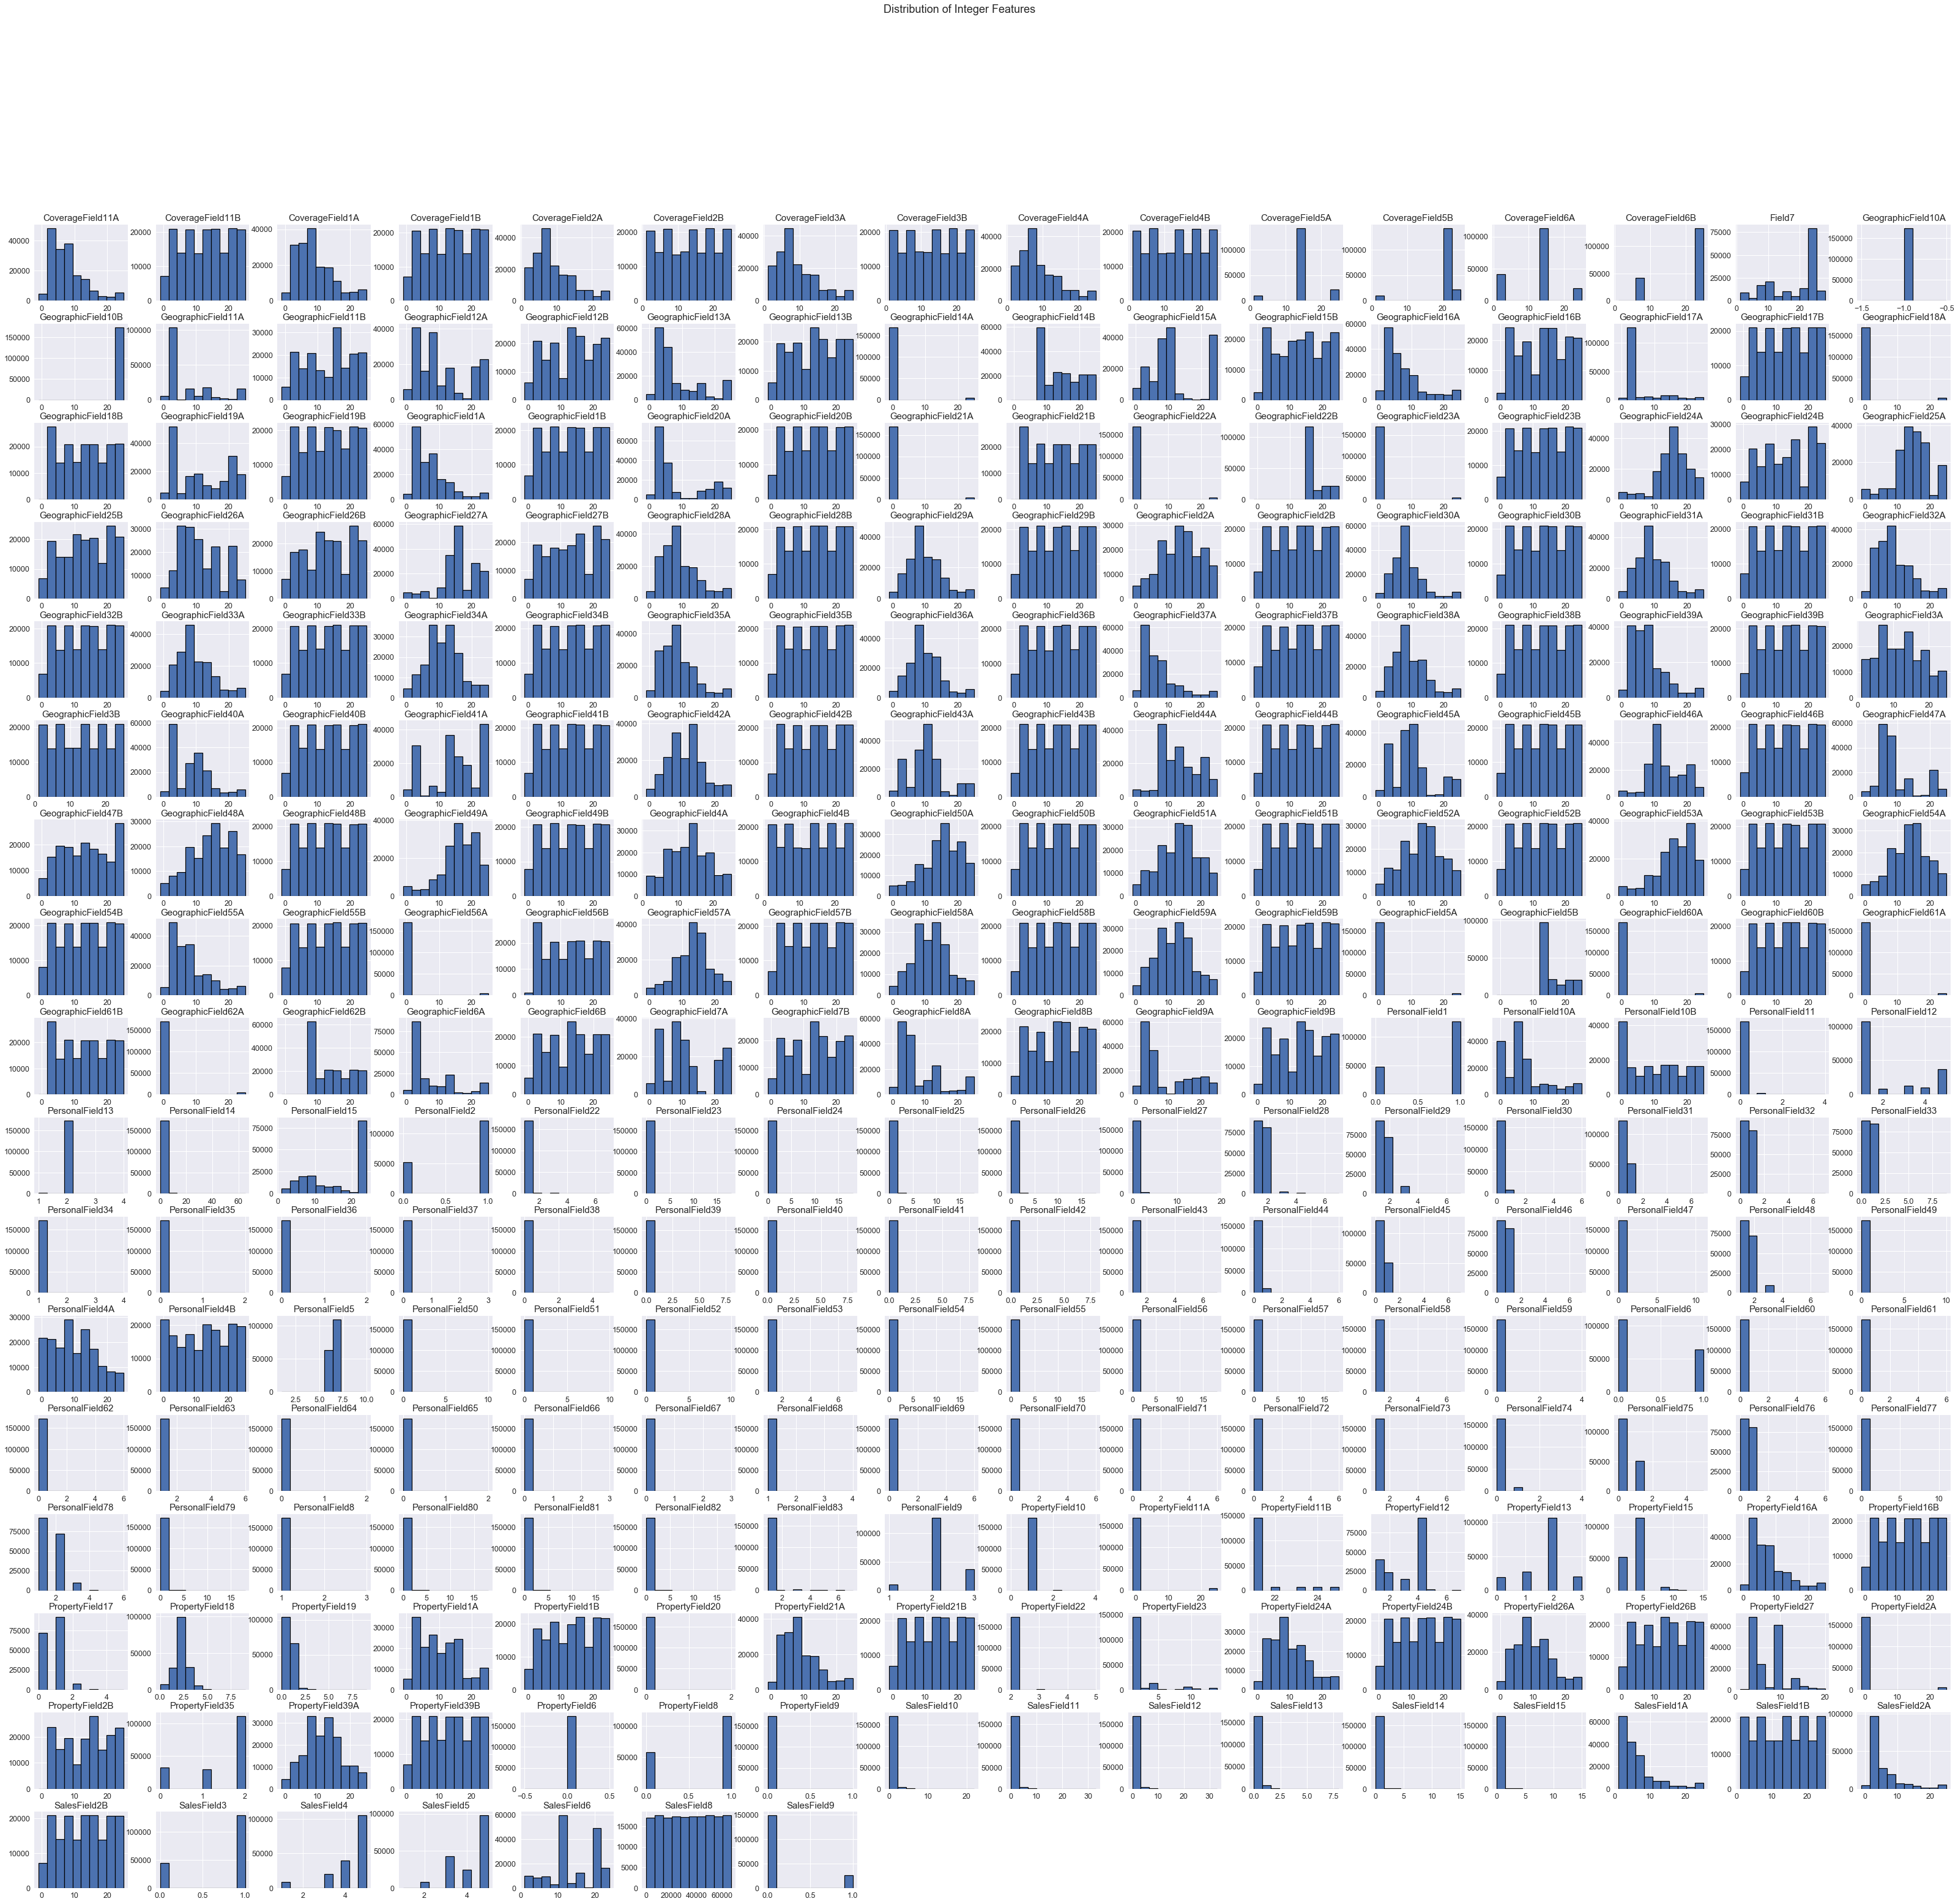

In [13]:
sns.set(font_scale=1.25)

testdf[int_columns].hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(50,50)
plt.suptitle("Distribution of Integer Features")
plt.show()

In [14]:
# personal field 23 as test
# want threshold to be 5%
int_col_filtered=[] # columns that at least have a 5% difference in frequency between the first and the second most common
problem_columns=[] #columns that are identical
for i in int_columns:
    value_series=testdf[i].value_counts().reset_index(drop=True)
    try:
        if value_series[1]*1.0/value_series[0] >= 0.1:
            int_col_filtered.append(i)
    except:
        problem_columns.append(i)

In [15]:
# very sharp and imbalanced / # kurtosis is tail /skew is distance away from normal
print skew(testdf['PersonalField23'])
print kurtosis(testdf['PersonalField23'])

17.0873721243
546.583101225


In [16]:
# well sprread
print skew(testdf['GeographicField50B'])
print kurtosis(testdf['GeographicField50B'])

-0.00287302793633
-1.19192444501


In [17]:
# very sharp and imbalanced
print skew(testdf['PersonalField9'])
print kurtosis(testdf['PersonalField9'])

0.299457403244
0.508631852273


In [18]:
# very sharp and imbalanced
print skew(testdf['SalesField4'])
print kurtosis(testdf['SalesField4'])

-1.82236863075
3.04757050937


In [19]:
# well sprread
print skew(testdf['GeographicField56A'])
print kurtosis(testdf['GeographicField56A'])

6.19554339704
36.3847579846


In [20]:
def spread_metrics(col):
    value_series=testdf[col].value_counts().reset_index(drop=True)
    print col
    print value_series.head()
    print value_series[1]*1.0/value_series[0]
    print 'skew: ' + str(skew(testdf[col]))
    print 'kurt: ' + str(kurtosis(testdf[col]))
spread_metrics('PersonalField9')

PersonalField9
0    127069
1     36633
2     10134
Name: PersonalField9, dtype: int64
0.28829218770903997
skew: 0.299457403244
kurt: 0.508631852273


In [21]:
kurtosis_analysis=pd.concat([testdf[int_col_filtered],traindf[int_col_filtered]]).apply(lambda x: kurtosis(x))
kurtosis_analysis=kurtosis_analysis.sort_values(ascending=False)
print kurtosis_analysis.head(20)
kurtosis_analysis.describe()

PersonalField14    39.264439
PersonalField27    34.105419
SalesField10       24.155331
SalesField12       23.012610
SalesField11       20.224671
PersonalField31    17.186991
PersonalField45    16.743608
PersonalField5     15.493136
PersonalField75    12.990904
PersonalField47    11.173314
PersonalField33    10.940248
CoverageField5B    10.867353
PersonalField32    10.594930
PersonalField46    10.499940
PersonalField77     8.526144
PersonalField76     7.886744
SalesField2A        5.030090
PersonalField28     4.688311
PropertyField19     3.786859
SalesField1A        3.653426
dtype: float64


count    185.000000
mean       1.159792
std        5.698461
min       -1.710382
25%       -1.203344
50%       -0.804446
75%        0.658336
max       39.264439
dtype: float64

#https://datascience.stackexchange.com/questions/9892/how-can-i-dynamically-distinguish-between-categorical-data-and-numerical-data
#### determination of categorical features that are represented as numeric 
If you have, for example, number of children of a family (which could range, for example, between 0 and 5), is it a categorical or numerical variable? Actually it depends on your problem and how you intend to solve it. In this sense, you can do the following:

- Compute the number of unique values of that column
- Divide this number by the total number of rows
- If this ratio is bellow some threshold (for example, 20%), you consider it categorical.
- In case of discrete values, one additional test could be: use a regression model to estimate some of the parameters and check if the estimated values are contained in the original set of values. If this is not true, you are probably dealing with categorical data (as it is the case of ZIP code).

# scale and ready for predictions

In [22]:
# do the above tests
actual_cat=[]
actual_int=[]
merged_ints=pd.concat([testdf[int_col_filtered],traindf[int_col_filtered]])
for col in int_col_filtered:
    if merged_ints[col].nunique()*1.0/merged_ints.shape[0] <= 0.2:
        actual_cat.append(col)
    else:
        actual_int.append(col)

In [23]:
# all integers should be categorical / merge all columns to scale
cat_col_final=actual_cat+cat_columns
cat_col_final=cat_col_final[:20] #take only first 20 to make model faster
cat_df_merged=pd.concat([traindf[cat_col_final],testdf[cat_col_final]]).applymap(str)
float_df_merged=pd.concat([traindf[float_columns],testdf[float_columns]])

In [24]:
traindf

,QuoteNumber,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,0,B,23,0.9403,0.0006,965,1.0200,N,17,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2,0,F,7,1.0006,0.0040,548,1.2433,N,6,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,0,F,7,1.0006,0.0040,548,1.2433,N,7,...,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,0,J,10,0.9769,0.0004,"1,165",1.2665,N,3,...,6,5,-1,10,-1,9,-1,21,N,TX
4,8,0,E,23,0.9472,0.0006,"1,487",1.3045,N,8,...,18,22,-1,10,-1,11,-1,12,N,IL
5,12,0,E,14,0.9472,0.0006,"1,487",1.3045,N,13,...,10,11,-1,23,-1,25,-1,14,N,IL
6,13,0,J,23,0.9258,0.0004,"1,165",1.2665,N,16,...,18,22,-1,19,-1,13,-1,8,N,TX
7,14,0,B,25,0.9153,0.0007,935,1.0200,N,5,...,6,5,-1,3,-1,12,-1,13,N,CA
8,18,0,J,10,0.9691,0.0004,"1,165",1.2665,N,5,...,2,1,-1,3,-1,2,-1,13,N,TX
9,19,0,F,11,0.9919,0.0038,564,1.1886,N,11,...,10,11,-1,9,-1,22,-1,18,N,NJ


df sets:
- float_columns
- cat_df_merged


In [25]:
# train scaler on training dataset
scaler=StandardScaler()
scaler.fit(traindf[float_columns])
train_float=scaler.transform(traindf[float_columns])
test_float=scaler.transform(testdf[float_columns])

In [26]:
# numeric columns created
train_float=pd.DataFrame(train_float)
train_float.columns=float_columns

test_float=pd.DataFrame(test_float)
test_float.columns=float_columns

y=traindf['QuoteConversion_Flag']

In [27]:
# dummies
merged_dummies=pd.get_dummies(cat_df_merged,drop_first=True)

In [28]:
dummytrain=merged_dummies[:len(traindf)]
dummytest=merged_dummies[len(traindf):]
# final train and test sets
trainfin=pd.concat([train_float,dummytrain],axis=1)
testfin=pd.concat([test_float,dummytest],axis=1)

In [29]:
print trainfin.shape
print testfin.shape

(260753, 384)
(173836, 384)


# using SMOTE for imblanced classes
https://www.kaggle.com/qianchao/smote-with-imbalance-data

# feature selection

In [32]:
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
xtrain=trainfin
xtest=testfin
Y=y
#feature selection
feats_25 = SelectPercentile(f_classif, 25).fit(xtrain, Y)
xtrain = feats_25.transform(xtrain)
xtest = feats_25.transform(xtest)

In [56]:
select_cols=[]
for i,j in zip(list(trainfin),feats_25.get_support()):
    if j==True:
        select_cols.append(i)

In [44]:
best_features=pd.DataFrame(zip(list(trainfin),feats_25.scores_)).sort_values(by=[1],ascending=False)
best_features.head(25)

,0,1
18,Field7_23,22339.928210
232,CoverageField6B_23,13585.334728
230,CoverageField6A_13,13585.334728
1,Field9,8688.088696
234,CoverageField6B_6,7814.169377
295,SalesField1A_2,6225.657269
0,Field8,4277.292407
20,Field7_25,3528.794227
233,CoverageField6B_25,3174.780015
231,CoverageField6A_25,3174.780015


# evaluate models

In [45]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_predict
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xg
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

In [57]:
xtrain=pd.DataFrame(xtrain)
xtrain.columns=select_cols

In [65]:
# only return 2000 of 0 class and 2000 of 1 class
train_selected=pd.concat([xtrain,y],axis=1)
train_selected=pd.concat([train_selected[merged_selected.QuoteConversion_Flag==0].sample(random_state=1,n=2000),train_selected[merged_selected.QuoteConversion_Flag==1].sample(random_state=1,n=2000)]).sort_index()
train_selected_index=train_selected.index

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

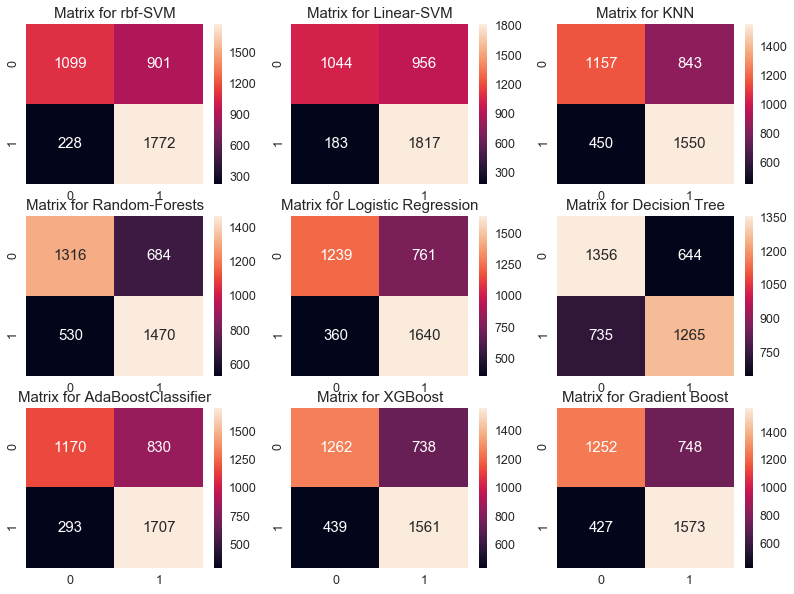

In [72]:
X=train_selected.drop(columns=['QuoteConversion_Flag'])
Y=train_selected['QuoteConversion_Flag']

f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf',class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')

y_pred = cross_val_predict(svm.SVC(kernel='linear',class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')

y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')

y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100,class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')

y_pred = cross_val_predict(LogisticRegression(class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')

y_pred = cross_val_predict(DecisionTreeClassifier(class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')

y_pred = cross_val_predict(AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for AdaBoostClassifier')

y_pred = cross_val_predict(xg.XGBClassifier(n_estimators=900,learning_rate=0.1),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,1],annot=True,fmt='2.0f')
ax[2,1].set_title('Matrix for XGBoost')

y_pred = cross_val_predict(GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,2],annot=True,fmt='2.0f')
ax[2,2].set_title('Matrix for Gradient Boost')



plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

In [86]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X, Y)
print 'roc_auc score'
print cross_val_score(clf, X, Y, cv=10, scoring='roc_auc').mean()

roc_auc score
0.77795875


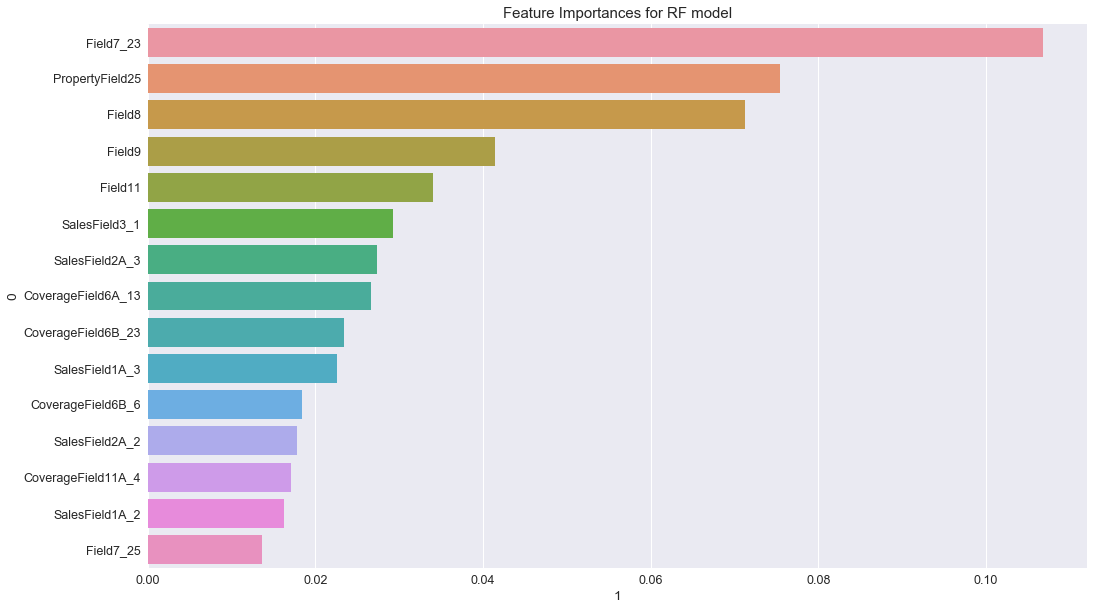

In [84]:
plt.figure(figsize=(15,10))
plt.title('Feature Importances for RF model')
sns.barplot(y=pd.DataFrame(zip(list(X),clf.feature_importances_)).sort_values(ascending=False,by=[1])[0].head(15),\
           x=pd.DataFrame(zip(list(X),clf.feature_importances_)).sort_values(ascending=False,by=[1])[1].head(15),orient='h')